# Load trade and production data (1993-2023)

In [1]:
import pandas as pd
import os
import numpy as np

trade_directory = "trade_data"

trades = []
for file in os.listdir(trade_directory):
    if file.endswith(".csv"): 
        trades.append(pd.read_csv(os.path.join(trade_directory, file),sep=",",index_col=False,encoding = 'ISO-8859-1'))


trade = pd.concat(trades,ignore_index=True, axis=0)
trade = trade[["refYear","reporterDesc","partnerDesc","flowDesc","qty","isAggregate"]].fillna(0.)

# fill gaps with with different imputation strategies

In [2]:
def need2be_imputed(tmp,target="qty"):
    zero_stat = []
    if len(tmp) > 0:
        right_empty = 0
        zeros = 0
        flag = True
        for i,row in tmp.reindex().sort_index(ascending=False).iterrows():
            if  math.isnan(row[target]):
                zeros += 1
                zero_stat.append(1)
                if flag:
                    right_empty += 1    
            else:
                flag = False
                zero_stat.append(0)
        if right_empty < 3 and zeros > 0:
            return True, 0, zero_stat
        else:    
            if zeros > 0 and right_empty == zeros:
                return False, right_empty, zero_stat
            else:
                if zeros == 0:
                    return False, 0, zero_stat
                else:    
                    return True, right_empty, zero_stat
    else:    
        return False, 0, zero_stat

In [3]:
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import AutoARIMA
from sklearn.metrics import mean_squared_error
import warnings
import math
from tqdm import tqdm
import copy

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
np.seterr(divide = 'ignore') 

reporters = np.unique(trade['reporterDesc'])

print("Original trade size:", len(trade))

# drop duplicate lines
print("Drop duplicates")
for r in tqdm(reporters):
    for partner in np.unique(trade[trade['reporterDesc'] == r]["partnerDesc"].to_numpy()):
        for flow in ["Import","Export"]:
            years = np.unique(trade["refYear"].to_numpy())
            for year in years:
                year_trade = trade[(trade['reporterDesc']==r)&(trade['flowDesc']==flow)&(trade['refYear']==year)&(trade['partnerDesc']==partner)]
                if len(year_trade) > 1:
                    remain = year_trade['qty'].idxmax()
                    #print(r,partner,len(year_trade))
                    for id_,_ in year_trade.iterrows():
                        if id_ != remain:
                            trade = trade.drop(id_)
                   #print("Control:",r,partner, len(trade[(trade['reporterDesc']==r)&(trade['flowDesc']==flow)&(trade['refYear']==year)&(trade['partnerDesc']==partner)]))        
print("Trade size after de-duplication:",len(trade))

print("Add missed values")
for r in tqdm(reporters):
    for partner in np.unique(trade[trade['reporterDesc'] == r]["partnerDesc"].to_numpy()):
        for flow in ["Import","Export"]:
            for year in years:
                if len(trade[(trade['reporterDesc']==r)&(trade['flowDesc']==flow)&(trade['refYear']==year)&(trade['partnerDesc']==partner)]) == 0:
                     row =  pd.DataFrame({"refYear":year,	"reporterDesc":r,	"partnerDesc":partner,	"flowDesc":flow,"qty":math.nan,	"isAggregate":False},index=[0])
                     trade = pd.concat([trade.loc[:],row],axis=0).reset_index(drop=True)

print("Impute nans")

trade_copy = copy.deepcopy(trade)

imputers = {"ARIMA":Imputer(method="forecaster", forecaster=AutoARIMA(suppress_warnings=True)), "FF":Imputer(method="ffill"),"INTERPOLATION":Imputer(method="linear"),"NO_IMP":None}

zero_cnts_years = {"Import":[],"Export":[]}

years = np.sort(np.unique(trade["refYear"].to_numpy())) # do not impute last 5 years

for imp_type in imputers:
    trade = copy.deepcopy(trade_copy)

    for r in tqdm(reporters):
        for partner in np.unique(trade[trade['reporterDesc'] == r]["partnerDesc"].to_numpy()):
            for flow in ["Import","Export"]:
                tmp = trade[(trade['reporterDesc']==r)&(trade['flowDesc']==flow)&(trade['partnerDesc']==partner)]
                flag,zero_len, zero_cnts = need2be_imputed(tmp)
                zero_cnts_years[flow].append(zero_cnts)
                if flag:
                    X = tmp.sort_values(by='refYear')
                    #TODO - set index
                    transformer = imputers[imp_type]
                    if transformer is not None:
                        X_ = transformer.fit_transform(X['qty'].to_numpy().flatten()[:len(X) - zero_len])
                        #print(X['qty'].to_numpy().flatten(), "-->", X_.flatten())
                        for i,v in enumerate(X.iterrows()):
                            idx, row = v
                            if i < len(X_) and row['refYear'] < years[-5]: # do not impute last 5 years
                                if X_[i] > 0.:
                                    trade.loc[idx,"qty"] = X_[i]
                                    #print(idx,row,"->",X_[i])
                            
    
    trade = trade.fillna(0.) # fill the remaining Nans with 0
    
    print("Final trade size:",len(trade))
    
    trade.to_csv("trade" + imp_type + ".csv",sep=";")


Original trade size: 117877
Drop duplicates


100%|███████████████████████████████████████| 211/211 [2:46:02<00:00, 47.21s/it]


Trade size after de-duplication: 91437
Add missed values


100%|██████████████████████████████████████| 211/211 [9:13:17<00:00, 157.34s/it]


Impute nans


100%|█████████████████████████████████████████| 211/211 [29:45<00:00,  8.46s/it]


Final trade size: 581684


100%|█████████████████████████████████████████| 211/211 [29:02<00:00,  8.26s/it]


Final trade size: 581684


100%|█████████████████████████████████████████| 211/211 [26:38<00:00,  7.58s/it]


Final trade size: 581684


100%|█████████████████████████████████████████| 211/211 [26:33<00:00,  7.55s/it]


Final trade size: 581684


In [4]:
trade_copy.to_csv("trade_copy.csv",sep=";")

In [5]:
pd.DataFrame(zero_cnts_years).to_csv("import_export_zero_stat.csv",sep=";")

# Prepare FAO

In [6]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm

trade = pd.read_csv("tradeARIMA.csv",sep=";",index_col=0)
reporters = np.unique(trade['reporterDesc'])

area_map = {"Belgium-Luxembourg":"Belgium-Luxembourg (...1998)",
"Bosnia and Herzegovina":"Bosnia Herzegovina",
"China, Taiwan Province of":"Taiwan",
"China, mainland":"China",
"Democratic People's Republic of Korea":"Democratic People's Republic of Korea",
"Democratic Republic of the Congo":"Dem. Rep. of the Congo",
"Iran (Islamic Republic of)":"Iran",
"Netherlands (Kingdom of the)":"Netherlands",
"Palestine":"State of Palestine",
"Republic of Korea":"Rep. of Korea",
"Republic of Moldova":"Rep. of Moldova",
"Serbia and Montenegro":"Serbia and Montenegro (...2005)",
"Somalia":"Somalia",
"South Sudan":"Sudan",
"Sudan (former)":"Sudan (...2011)",
"Syrian Arab Republic":"Syria",
"United Kingdom of Great Britain and Northern Ireland":"United Kingdom",
"United Republic of Tanzania":"United Rep. of Tanzania",
"United States of America":"USA",
"Venezuela (Bolivarian Republic of)":"Venezuela"}

area_map_inv = {v:k for k,v in area_map.items()}

from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import AutoARIMA
from sklearn.metrics import mean_squared_error
import warnings
import copy

fao = pd.read_csv("prod_data/FAOSTAT_data_en_1-28-2025.csv")[["Area", "Year", "Value"]]

years = np.unique(trade["refYear"].to_numpy())
areas = np.unique(trade['reporterDesc'].to_numpy())

zero_cnts_years = {"Production":[]}

fao_copy = copy.deepcopy(fao)

imputers = {"ARIMA":Imputer(method="forecaster", forecaster=AutoARIMA(suppress_warnings=True)), "FF":Imputer(method="ffill"),"INTERPOLATION":Imputer(method="linear"),"NO_IMP":None}

for imp_type in imputers:
    fao = copy.deepcopy(fao_copy)

    for r in areas:
        if r in area_map_inv:
            print(area_map_inv[r],"-->",r)
            for idx,row in fao[fao["Area"] == area_map_inv[r]].iterrows():
                row["Area"] = r
                fao.loc[idx] = row
        
    
        for year in years:
            if len(fao[(fao['Area']==r)&(fao['Year']==year)]) == 0:
                 row =  pd.DataFrame({"Area":r,	"Year":year,"Value":math.nan},index=[0])
                 fao = pd.concat([fao.loc[:],row],axis=0).reset_index(drop=True)
                
    
        #if empty:        
        #    print("Zeros: ", r)
        tmp = fao[(fao['Area']==r)]
        flag,zero_len,zero_cnts = need2be_imputed(tmp,"Value")
        zero_cnts_years["Production"].append(zero_cnts)
        
        if flag:
            X = tmp.sort_values(by='Year')
            transformer = imputers[imp_type]
            if transformer is not None:
                X_ = transformer.fit_transform(X['Value'].to_numpy().flatten()[:len(X) - zero_len])
        
                #print(X['Value'].to_numpy().flatten(), "-->", X_.flatten())
                for i,v in enumerate(X.iterrows()):
                    idx, row = v
                    if i < len(X_) and row['Year'] < years[-5]: # do not impute last 5 years
                        if X_[i] > 0.:
                            fao.loc[idx,"Value"] = X_[i]  
                            print(idx,row,'->',X_[i])
    
    print("Drop duplicates")
    for r in tqdm(areas):
        for year in years:
            year_trade = fao[(fao['Area']==r)&(fao['Year']==year)]
            if len(year_trade) > 1:
                remain = year_trade['Value'].idxmax()
                print(r,len(year_trade))
                for id_,_ in year_trade.iterrows():
                    if id_ != remain:
                        fao = fao.drop(id_)
                        
    fao = fao.fillna(0.)
    fao.to_csv("fao" + imp_type + ".csv",sep=";")

Belgium-Luxembourg --> Belgium-Luxembourg (...1998)
Bosnia and Herzegovina --> Bosnia Herzegovina
China, mainland --> China
Democratic Republic of the Congo --> Dem. Rep. of the Congo
Iran (Islamic Republic of) --> Iran
Netherlands (Kingdom of the) --> Netherlands
Republic of Korea --> Rep. of Korea
Republic of Moldova --> Rep. of Moldova
Serbia and Montenegro --> Serbia and Montenegro (...2005)
Palestine --> State of Palestine
2677 Area     State of Palestine
Year                   1993
Value                   NaN
Name: 2677, dtype: object -> [32483.45721171]
2678 Area     State of Palestine
Year                   1994
Value               18241.0
Name: 2678, dtype: object -> [18241.]
2679 Area     State of Palestine
Year                   1995
Value               40732.0
Name: 2679, dtype: object -> [40732.]
2680 Area     State of Palestine
Year                   1996
Value               30872.0
Name: 2680, dtype: object -> [30872.]
2681 Area     State of Palestine
Year               

 21%|████████▉                                 | 45/211 [00:00<00:03, 46.02it/s]

China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2


 89%|████████████████████████████████████▎    | 187/211 [00:03<00:00, 49.20it/s]

Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2


100%|█████████████████████████████████████████| 211/211 [00:04<00:00, 49.18it/s]


Belgium-Luxembourg --> Belgium-Luxembourg (...1998)
Bosnia and Herzegovina --> Bosnia Herzegovina
China, mainland --> China
Democratic Republic of the Congo --> Dem. Rep. of the Congo
Iran (Islamic Republic of) --> Iran
Netherlands (Kingdom of the) --> Netherlands
Republic of Korea --> Rep. of Korea
Republic of Moldova --> Rep. of Moldova
Serbia and Montenegro --> Serbia and Montenegro (...2005)
Palestine --> State of Palestine
2677 Area     State of Palestine
Year                   1993
Value                   NaN
Name: 2677, dtype: object -> [18241.]
2678 Area     State of Palestine
Year                   1994
Value               18241.0
Name: 2678, dtype: object -> [18241.]
2679 Area     State of Palestine
Year                   1995
Value               40732.0
Name: 2679, dtype: object -> [40732.]
2680 Area     State of Palestine
Year                   1996
Value               30872.0
Name: 2680, dtype: object -> [30872.]
2681 Area     State of Palestine
Year                   1997

 21%|████████▉                                 | 45/211 [00:00<00:03, 47.00it/s]

China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2


 89%|████████████████████████████████████▌    | 188/211 [00:03<00:00, 50.45it/s]

Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2


100%|█████████████████████████████████████████| 211/211 [00:04<00:00, 49.94it/s]


Belgium-Luxembourg --> Belgium-Luxembourg (...1998)
Bosnia and Herzegovina --> Bosnia Herzegovina
China, mainland --> China
Democratic Republic of the Congo --> Dem. Rep. of the Congo
Iran (Islamic Republic of) --> Iran
Netherlands (Kingdom of the) --> Netherlands
Republic of Korea --> Rep. of Korea
Republic of Moldova --> Rep. of Moldova
Serbia and Montenegro --> Serbia and Montenegro (...2005)
Palestine --> State of Palestine
2677 Area     State of Palestine
Year                   1993
Value                   NaN
Name: 2677, dtype: object -> [18241.]
2678 Area     State of Palestine
Year                   1994
Value               18241.0
Name: 2678, dtype: object -> [18241.]
2679 Area     State of Palestine
Year                   1995
Value               40732.0
Name: 2679, dtype: object -> [40732.]
2680 Area     State of Palestine
Year                   1996
Value               30872.0
Name: 2680, dtype: object -> [30872.]
2681 Area     State of Palestine
Year                   1997

 23%|█████████▌                                | 48/211 [00:00<00:03, 47.97it/s]

China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2


 88%|███████████████████████████████████▉     | 185/211 [00:03<00:00, 49.93it/s]

Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2


100%|█████████████████████████████████████████| 211/211 [00:04<00:00, 50.08it/s]


Belgium-Luxembourg --> Belgium-Luxembourg (...1998)
Bosnia and Herzegovina --> Bosnia Herzegovina
China, mainland --> China
Democratic Republic of the Congo --> Dem. Rep. of the Congo
Iran (Islamic Republic of) --> Iran
Netherlands (Kingdom of the) --> Netherlands
Republic of Korea --> Rep. of Korea
Republic of Moldova --> Rep. of Moldova
Serbia and Montenegro --> Serbia and Montenegro (...2005)
Palestine --> State of Palestine
South Sudan --> Sudan
Sudan (former) --> Sudan (...2011)
Syrian Arab Republic --> Syria
United States of America --> USA
United Kingdom of Great Britain and Northern Ireland --> United Kingdom
United Republic of Tanzania --> United Rep. of Tanzania
Venezuela (Bolivarian Republic of) --> Venezuela
Drop duplicates


 23%|█████████▊                                | 49/211 [00:00<00:03, 48.39it/s]

China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2


 88%|███████████████████████████████████▉     | 185/211 [00:03<00:00, 49.84it/s]

Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2


100%|█████████████████████████████████████████| 211/211 [00:04<00:00, 49.98it/s]


## Calc norm constants

In [7]:
from tqdm import tqdm

import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import AutoARIMA

import warnings
import pandas as pd

for imp_type in ["ARIMA", "FF","INTERPOLATION","NO_IMP"]:
    trade = pd.read_csv("trade" + imp_type + ".csv",sep=";")
    fao = pd.read_csv("fao" + imp_type + ".csv",sep=";")
    reporters = np.unique(trade['reporterDesc'])

    datas = []
    part_offset = []
    for r in tqdm(reporters):
        for partner in np.unique(trade[trade['reporterDesc'] == r]["partnerDesc"].to_numpy()):
            if r.find(", nes")==-1 and r.find("North America")==-1 and r.find("World") == -1 and  r.find("Union") == -1 and r.find("19") == -1 and r.find("20") == -1:
                if partner.find(", nes")==-1 and partner.find("North America")==-1 and partner.find("World") == -1 and  partner.find("Union") == -1 and partner.find("19") == -1 and partner.find("20") == -1:             
                    #print(r,partner)
                    data = np.nan_to_num(trade[(trade['reporterDesc'] == r)&(trade['partnerDesc'] == partner)&(trade['flowDesc'] == "Export")].sort_values(by='refYear')['qty'].to_numpy().reshape(1,-1,1))
                    data2 = np.nan_to_num(trade[(trade['reporterDesc'] == r)&(trade['partnerDesc'] == partner)&(trade['flowDesc'] == "Import")].sort_values(by='refYear')['qty'].to_numpy().reshape(1,-1,1))
                    data3 = np.nan_to_num(fao[fao["Area"] == r].sort_values(by='Year')[["Value"]].to_numpy().reshape(1,-1,1))
                    data4 = np.nan_to_num(fao[fao["Area"] == partner].sort_values(by='Year')[["Value"]].to_numpy().reshape(1,-1,1))
                    if data4.shape[1] > 0 and data3.shape[1] > 0:
                        #print(data.shape,data2.shape,data3.shape,data4.shape)
                        data = np.concatenate([data,data2,data3,data4],axis=2)
                        datas.append(data)
                        part_offset.append((r,partner,len(datas) - 0))
    
    base_dataset = np.vstack(datas)
    
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=UserWarning)
    np.seterr(divide = 'ignore')
    
    base_datasetX = base_dataset[:,:30,:]
    base_datasety = base_dataset[:,1:31,0]
    
    #remove lines with many zeros
    remain_idxs = (np.abs(base_datasety) < 500000).sum(axis=1) < 2
    
    base_datasetX = base_datasetX[remain_idxs].reshape(-1,5,4)
    base_datasety = base_datasety[remain_idxs]
    
    #normalize
    nz_idxs_y = (base_datasety.reshape(-1,5).sum(axis=1) > 0).flatten()
    nz_idx_x = (base_datasetX.sum(axis=1) > 0).prod(axis=1).astype(bool)
    res_idx = nz_idxs_y * nz_idx_x
    
    features_min = base_datasetX[res_idx].reshape(-1,base_datasetX.shape[2]).min(axis=0)
    features_max = base_datasetX[res_idx].reshape(-1,base_datasetX.shape[2]).max(axis=0)
    
    np.save("norm_constants" + imp_type + ".npy",np.asarray([features_min, features_max]))

100%|█████████████████████████████████████████| 211/211 [24:53<00:00,  7.08s/it]


# Build graph dataset

In [ ]:
## Build a trade map for clustering

0
1
2


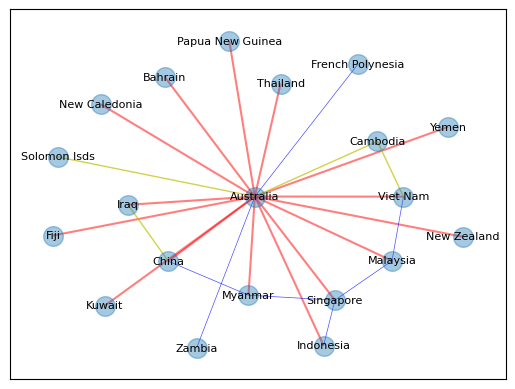

3
4


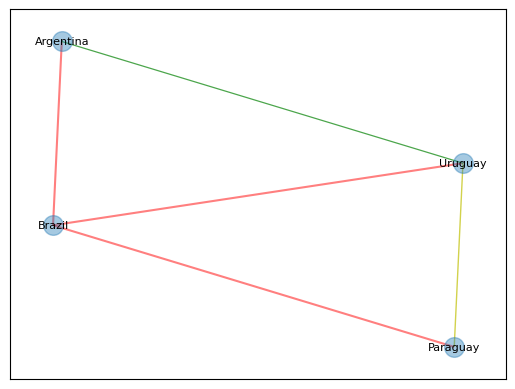

5


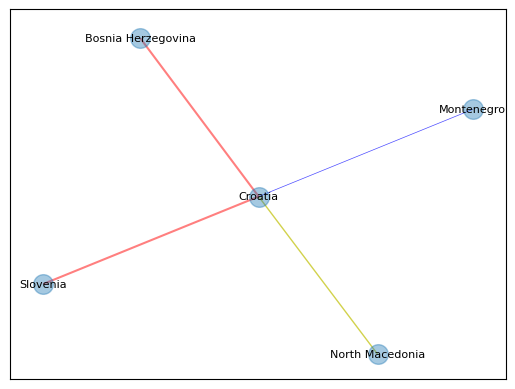

6
7


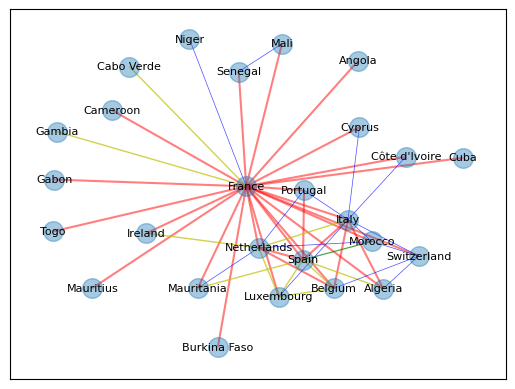

8
9


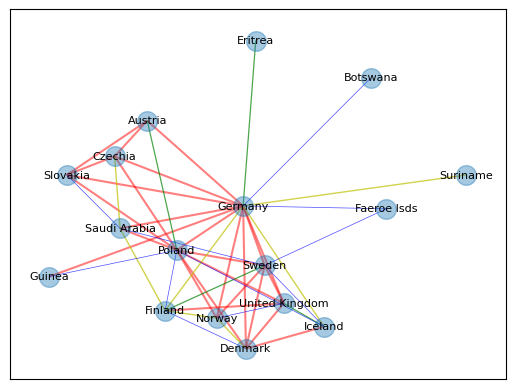

10
11
12


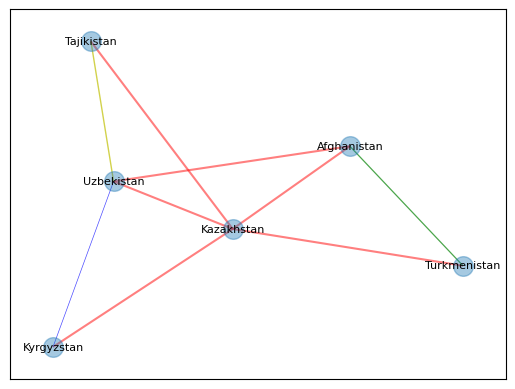

13
14


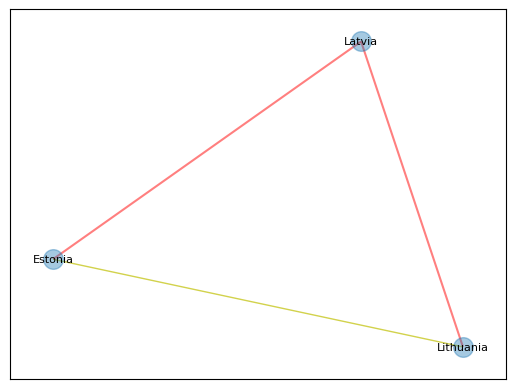

15
16
17
18


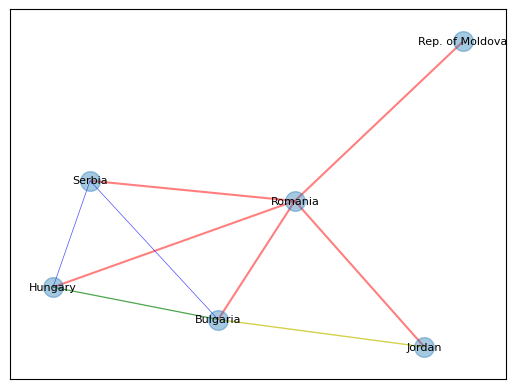

19


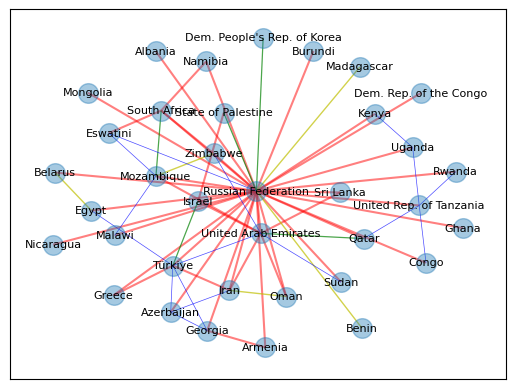

20
21


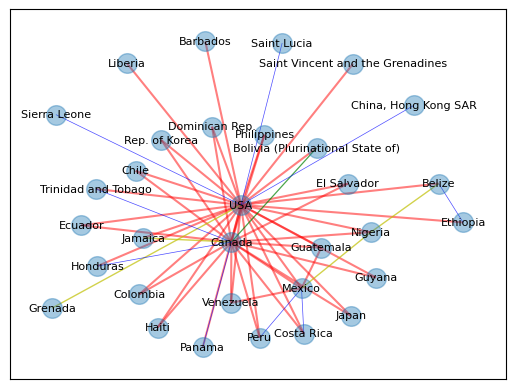

22


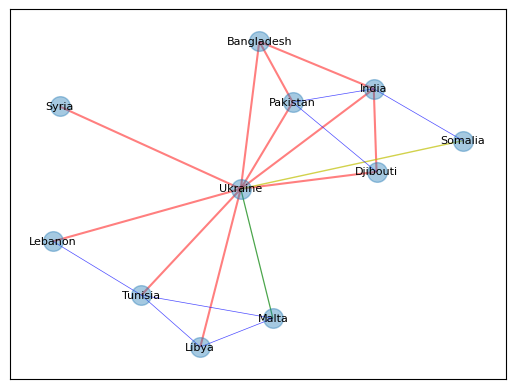

23
24
Cluster  0
Cluster  1
Cluster  2
Cluster  3
Cluster  4
Cluster  5
Cluster  6
Cluster  7
Cluster  8
Cluster  9
Cluster  10
Cluster  11
Cluster  12
Cluster  13
Cluster  14
Cluster  15
Cluster  16
Cluster  17
Cluster  18
Cluster  19
Cluster  20
Cluster  21
Cluster  22
Cluster  23
Cluster  24
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
0
1


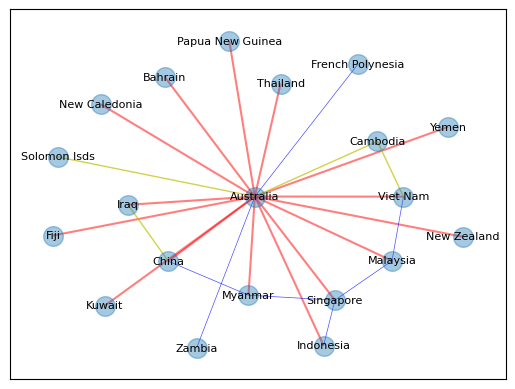

2
3


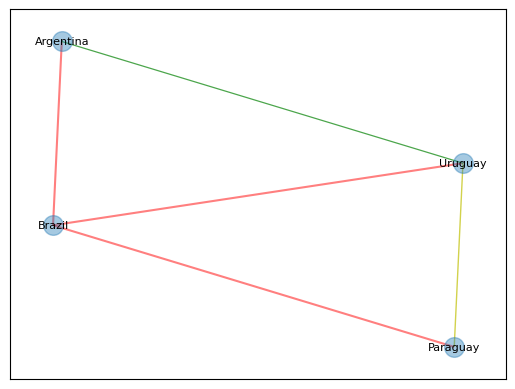

4
5


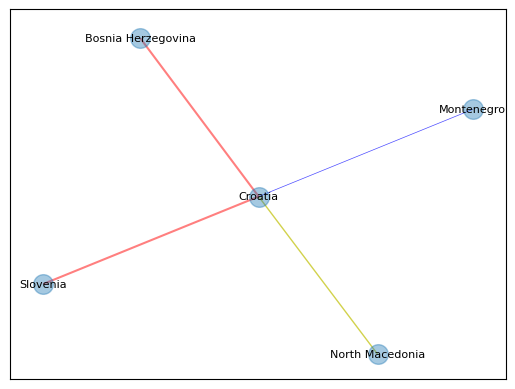

6


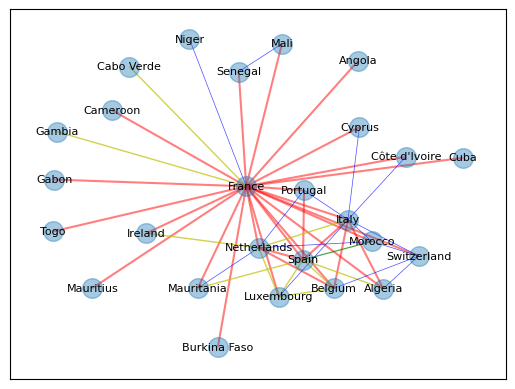

7


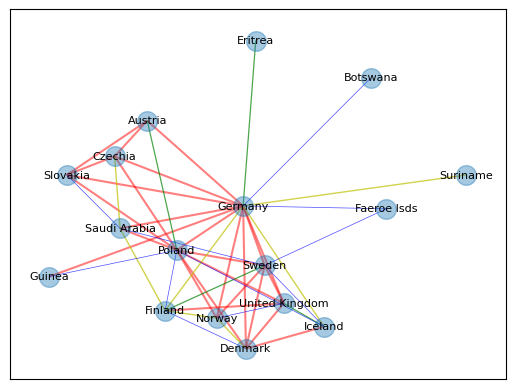

8
9


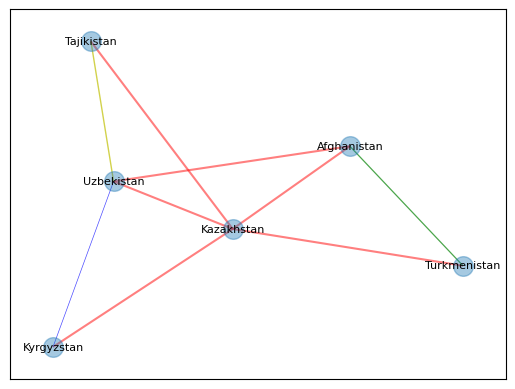

10
11


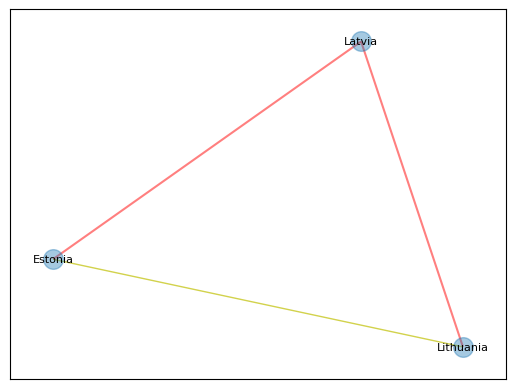

12
13


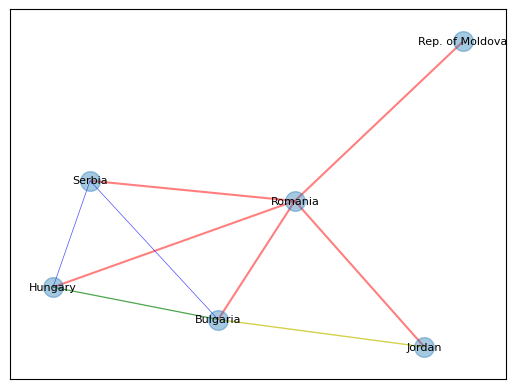

14


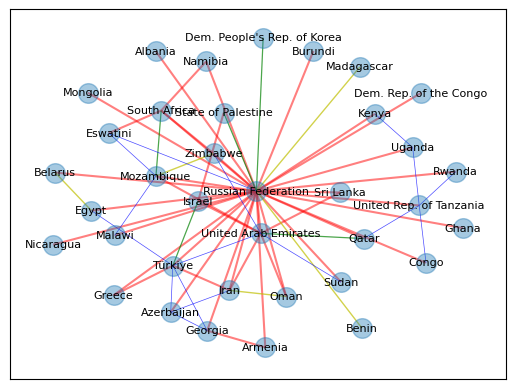

15
16
17
18
19
20
21


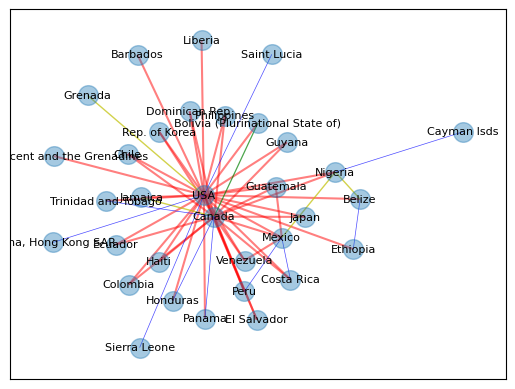

22


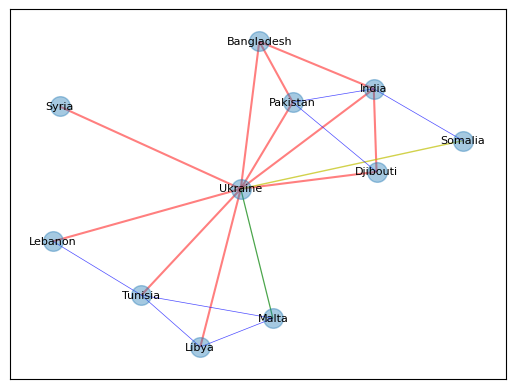

Cluster  0
Cluster  1
Cluster  2
Cluster  3
Cluster  4
Cluster  5
Cluster  6
Cluster  7
Cluster  8
Cluster  9
Cluster  10
Cluster  11
Cluster  12
Cluster  13
Cluster  14
Cluster  15
Cluster  16
Cluster  17
Cluster  18
Cluster  19
Cluster  20
Cluster  21
Cluster  22
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
0
1


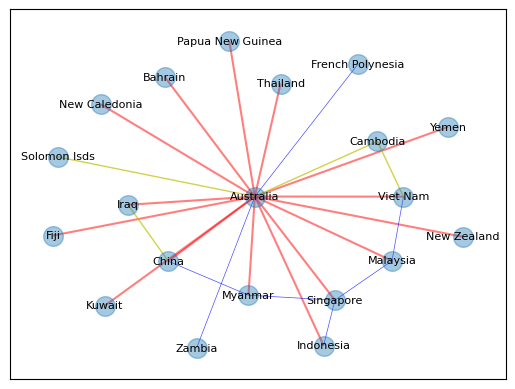

2


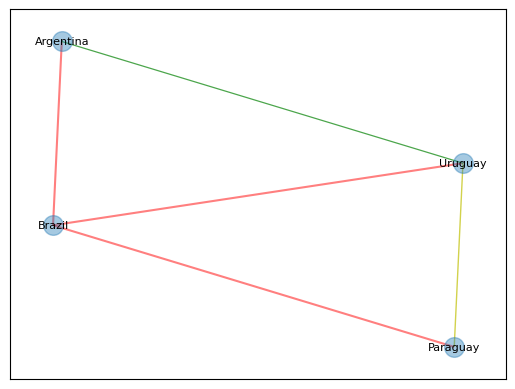

3
4
5


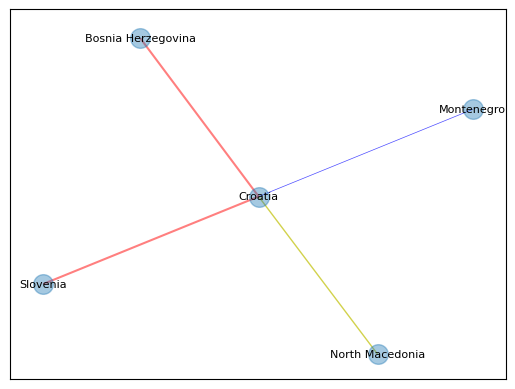

6
7
8


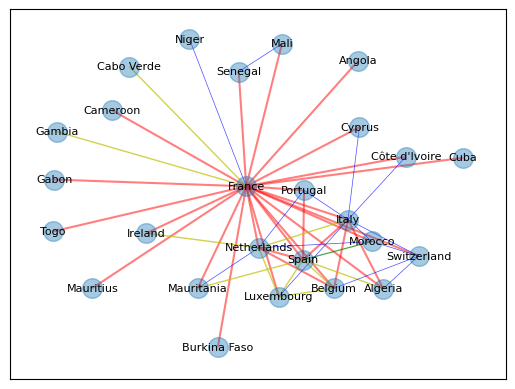

9


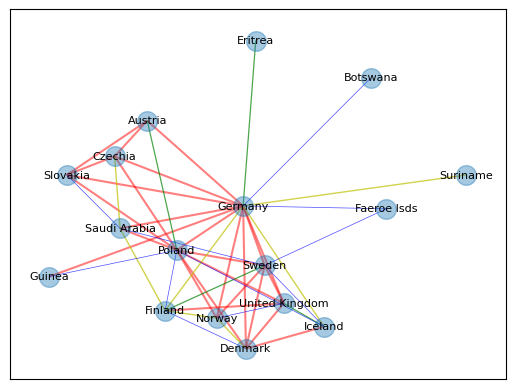

10
11


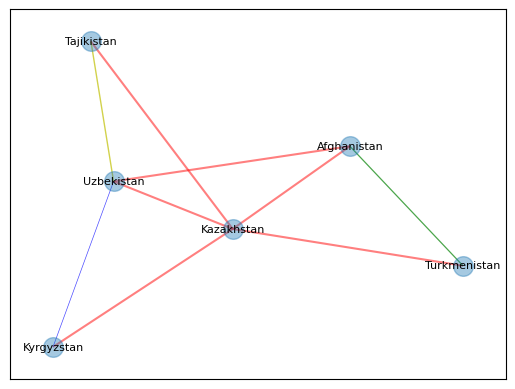

12
13


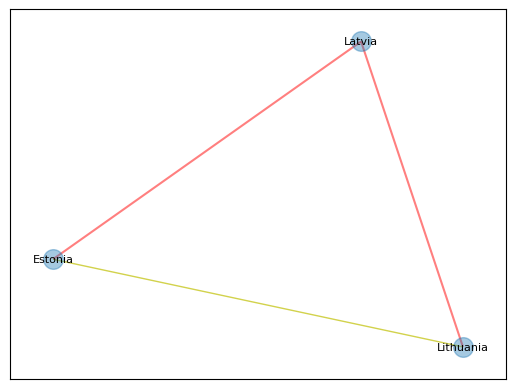

14


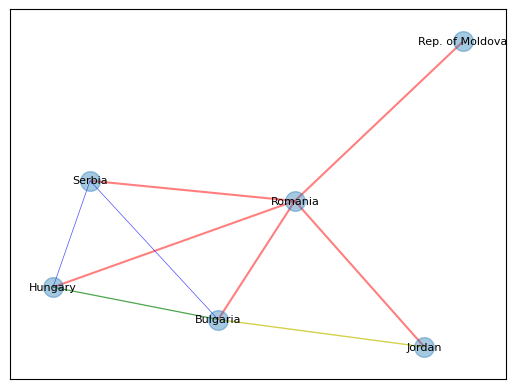

15


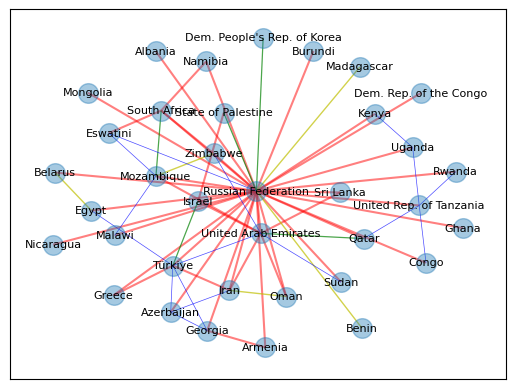

16
17


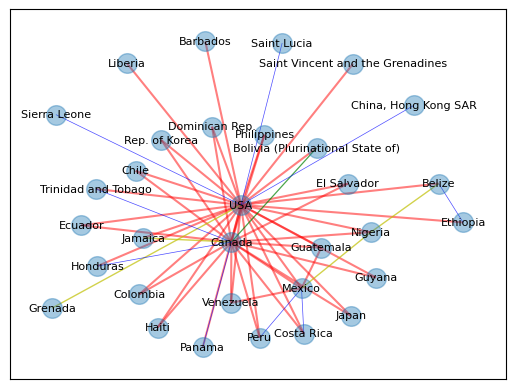

18


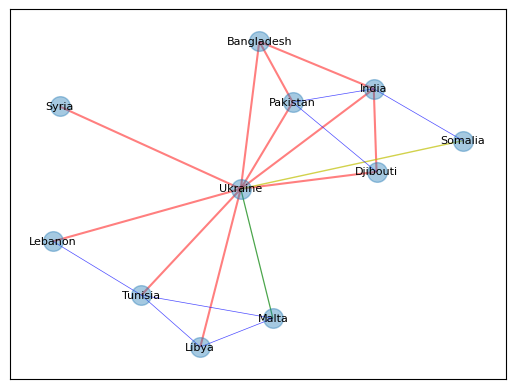

19
Cluster  0
Cluster  1
Cluster  2
Cluster  3
Cluster  4
Cluster  5
Cluster  6
Cluster  7
Cluster  8
Cluster  9
Cluster  10
Cluster  11
Cluster  12
Cluster  13
Cluster  14
Cluster  15
Cluster  16
Cluster  17
Cluster  18
Cluster  19
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
0


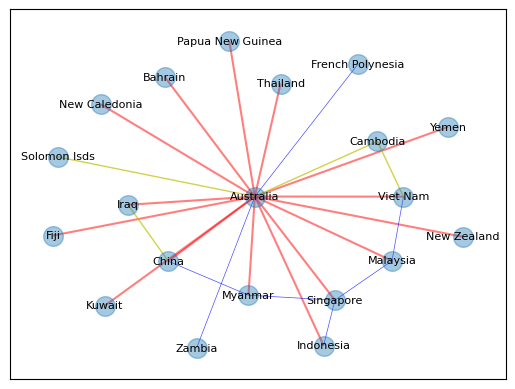

1
2


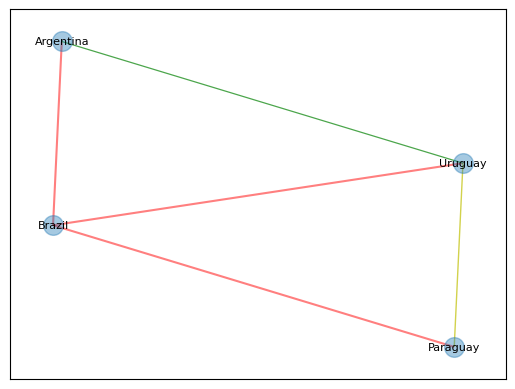

3
4
5


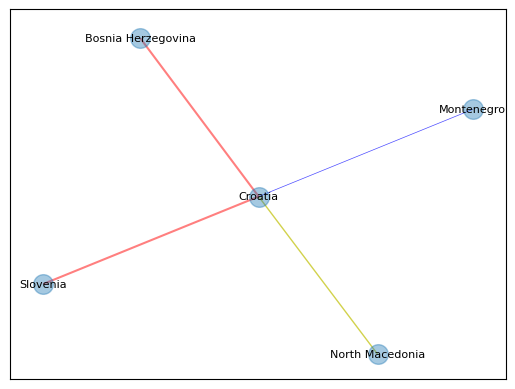

6
7


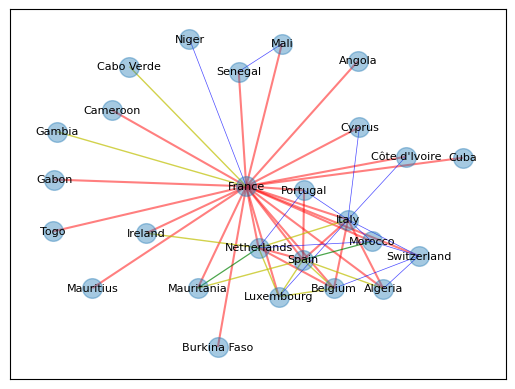

8


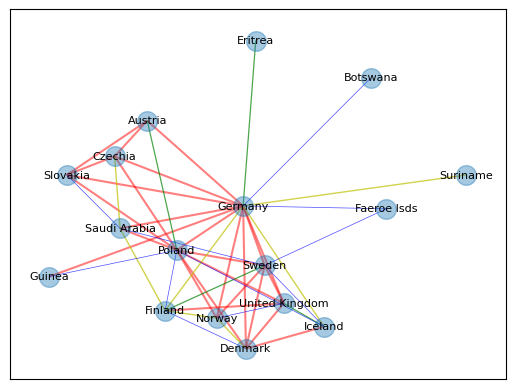

9
10
11


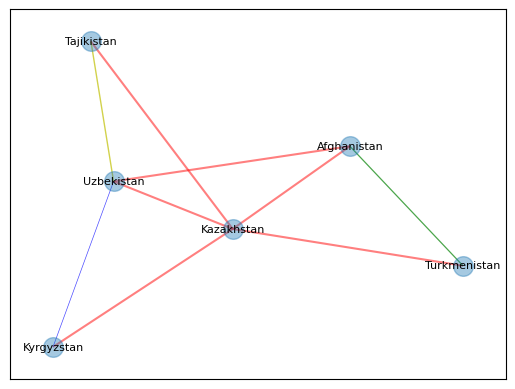

12


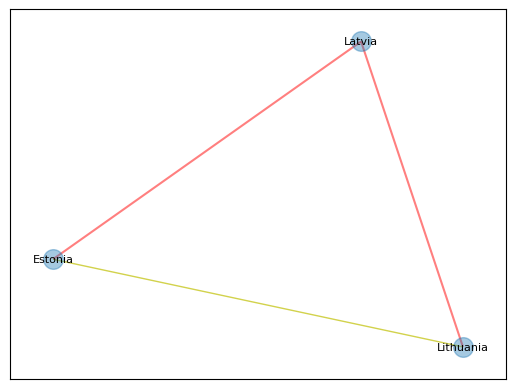

13
14
15


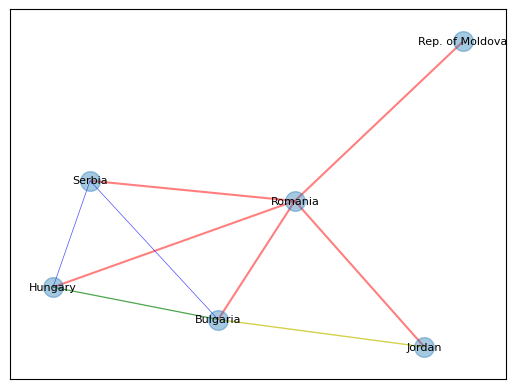

16


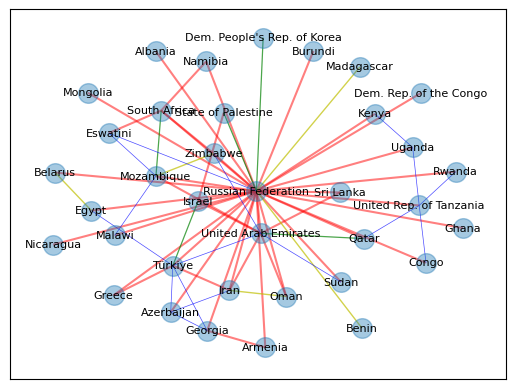

17
18
19


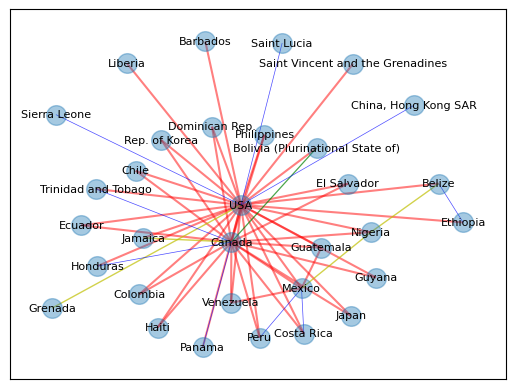

20


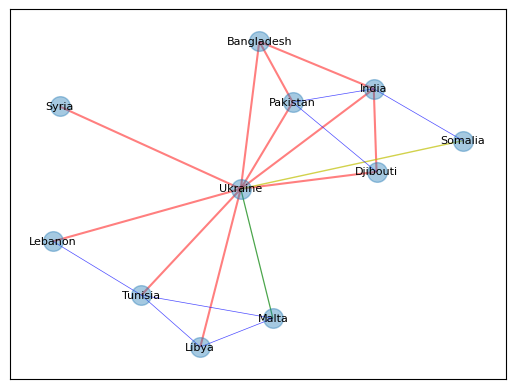

21
Cluster  0
Cluster  1
Cluster  2
Cluster  3
Cluster  4
Cluster  5
Cluster  6
Cluster  7
Cluster  8
Cluster  9
Cluster  10
Cluster  11
Cluster  12
Cluster  13
Cluster  14
Cluster  15
Cluster  16
Cluster  17
Cluster  18
Cluster  19
Cluster  20
Cluster  21
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------


In [16]:
import pandas as pd
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from scipy.sparse import coo_matrix
from sklearn.preprocessing import LabelEncoder
import copy
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import AutoARIMA
import pickle

def all_not_empty(cluster_year):
    #cluster_year.append({})
    #id_ = len(cluster_year)
    print("-----------------")
    for j,k in cluster_year[1]:
        a = cluster_year[1][j,k][0]
        b = cluster_year[1][j,k][1]
        zero_map = b == 0
        #cluster_year[id_][(j,k)] = zero_map
        if len(b[zero_map]) > 0:
            #print(i,j,a,b)
            return False
    return True        

top10 = np.asarray(["Russian Federation", "Australia", "USA", "Canada", "Ukraine", "France", "Argentina", "Germany", "Romania", "India"])
imputers = {"ARIMA":Imputer(method="forecaster", forecaster=AutoARIMA(suppress_warnings=True)), "FF":Imputer(method="ffill"),"INTERPOLATION":Imputer(method="linear"),"NO_IMP":None}

for imp_type in ["ARIMA", "FF","INTERPOLATION","NO_IMP"]:
    trade = pd.read_csv("trade" + imp_type + ".csv",sep=";")
    trade_aggregate = trade[trade["refYear"] > 2010][["reporterDesc","partnerDesc","qty"]].groupby(["reporterDesc","partnerDesc"]).mean()["qty"]
    
    trade_map = []
    for i,v in trade_aggregate.items():
        if i[0].find(", nes")==-1 and i[0].find("North America")==-1 and i[0].find("World") == -1 and  i[0].find("Union") == -1 and i[0].find("19") == -1 and i[0].find("20") == -1:
            if i[1].find(", nes")==-1 and i[1].find("North America")==-1 and i[1].find("World") == -1 and  i[1].find("Union") == -1 and i[1].find("19") == -1 and i[1].find("20") == -1:
                trade_map.append([i[0],i[1],v])
    
    trade_map = np.asarray(trade_map)
    
    le = OrdinalEncoder(handle_unknown='use_encoded_value',
                                     unknown_value=-1)
    
    le.fit(trade_map[:,:2].reshape(-1,1))
    row = le.transform(trade_map[:,0].reshape(-1,1)).astype(int).flatten()
    col = le.transform(trade_map[:,1].reshape(-1,1)).astype(int).flatten()
    data = trade_map[:,2].astype(float)
    num_labels = le.categories_[0].shape[0]
    
    trade_map_sparse = coo_matrix((data, (row, col)),shape=(num_labels, num_labels)).tolil()
    
    for i in range(trade_map_sparse.shape[0]):
        for j in range(i,trade_map_sparse.shape[1]):
            if i == j:
                trade_map_sparse[i,j] = 0.
            trade_map_sparse[i,j] = (trade_map_sparse[i,j] + trade_map_sparse[j,i]) / 2
            if trade_map_sparse[i,j] < 500000.:
                trade_map_sparse[i,j] = 0.
            trade_map_sparse[j,i] = trade_map_sparse[i,j]
            
    trade_map_sparse = trade_map_sparse.tocsr()
    
    trade_export = trade[trade["flowDesc"] == "Export"][["refYear","reporterDesc","partnerDesc","qty"]]
    trade_export = trade_export.to_numpy()
    trade_export = np.hstack([trade_export[:,0].reshape(-1,1),le.transform(trade_export[:,1].reshape(-1,1)).astype(int), le.transform(trade_export[:,2].reshape(-1,1)).astype(int),trade_export[:,3].reshape(-1,1)])    
    trade_import = trade[trade["flowDesc"] == "Import"][["refYear","reporterDesc","partnerDesc","qty"]]
    trade_import = trade_import.to_numpy()
    trade_import = np.hstack([trade_import[:,0].reshape(-1,1),le.transform(trade_import[:,1].reshape(-1,1)).astype(int), le.transform(trade_import[:,2].reshape(-1,1)).astype(int),trade_import[:,3].reshape(-1,1)])
    preference = - np.ones((num_labels,))
    idx = le.transform(top10.reshape(-1,1)).astype(int).flatten()
    preference[idx] = 0.

    
    model = AffinityPropagation(affinity="precomputed",max_iter=10000,preference = None,damping=0.5)
    aff_map = trade_map_sparse.toarray()
    aff_map = np.nan_to_num(aff_map)
    
    clustering = model.fit_predict(aff_map)
    
    ids, counts = np.unique(clustering, return_counts = True)
    
    avg_weight = trade_map_sparse.mean()
    
    for i,c in enumerate(ids):
        print(c)
        G = nx.Graph()
    
        for j in range(clustering.shape[0]):
            if clustering[j] == c:
                #print(c,le.inverse_transform([j])[0])
                for k in range(clustering.shape[0]):
                    if clustering[k] == c:
                        if  trade_map_sparse[j,k] > 0.:
                            #print(c,le.inverse_transform([j])[0], le.inverse_transform([k])[0], trade_map_sparse[j,k])
                            G.add_edge(le.inverse_transform([[j]])[0][0], le.inverse_transform([[k]])[0][0], weight= trade_map_sparse[j,k])
                            
        elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > avg_weight*2.5]
        ealarge = [(u, v) for (u, v, d) in G.edges(data=True) if ((d["weight"] > avg_weight*1.2) and (d["weight"] <= avg_weight*2.5))]
        emed = [(u, v) for (u, v, d) in G.edges(data=True) if ((d["weight"] > avg_weight*0.8) and (d["weight"] <= avg_weight*1.2))]
        esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= avg_weight*0.8]
    
        if len(elarge + esmall+emed+ealarge) > 2 and len(elarge) > 0:
            layout = nx.spring_layout(G, seed=7,weight=None)
            #nx.draw(G, layout)
            nx.draw_networkx_nodes(G, layout, node_size=200,alpha=0.4)
        
            # edges
            nx.draw_networkx_edges(G, layout, edgelist=elarge, width=1.5,alpha=0.5,edge_color="r")
            nx.draw_networkx_edges(
                G, layout, edgelist=ealarge, width=1.0, alpha=0.7, edge_color="y"
            )           
            nx.draw_networkx_edges(
                G, layout, edgelist=emed, width=0.9, alpha=0.7, edge_color="g"
            )        
            nx.draw_networkx_edges(
                G, layout, edgelist=esmall, width=0.5, alpha=0.7, edge_color="b"
            )
            
            # node labels
            nx.draw_networkx_labels(G, layout, font_size=8, font_family="sans-serif")
            # edge weight labels
            #edge_labels = nx.get_edge_attributes(G, "weight")
            #nx.draw_networkx_edge_labels(G, layout, edge_labels,font_size=6)
            plt.show()   
            years = np.unique(trade_export[:,0])

    trade_clusters = []
    #; un['num_states'] : nb of states, an integer (N)
    #; un['production'] : tensor of size N, each element is a production value, a float number > 0
    #; un['export'] : tensor of size N x N, each element is a value of export, a float number > 0
    #; un['pred_export']
    
    cluster_year = {}
    
    for i,c in enumerate(ids):
        print("Cluster ",c)
        for year in range(1993,2023,5):
            countries = {}
            cdata = {}
            for j in range(clustering.shape[0]):
                if clustering[j] == c:
                    for k in range(clustering.shape[0]):
                        if clustering[k] == c:
                            ty = trade_export[(trade_export[:,0] >= year)&(trade_export[:,0] < year + 7)&(trade_export[:,1] == j)&(trade_export[:,2] == k)]
                            tyi = trade_import[(trade_import[:,0] >= year)&(trade_import[:,0] < year + 7)&(trade_import[:,1] == j)&(trade_import[:,2] == k)]
                            if len(ty) > 0:
                                countries[j] = True
                                countries[k] = True
                                datas = np.zeros((5,2))
                                targets = np.zeros((5,))
                                too_small_flag = 0
                                for y in range(year,year + 5):
                                    val = ty[ty[:,0] == y]
                                    imp_val = tyi[tyi[:,0] == y]
                                    if len(val) > 0:
                                        if val[0,3] < 500000:
                                            too_small_flag += 1    
                                        datas[y - year,0] = val[0,3]
    
                                        if len(imp_val) > 0:
                                            datas[y - year,1] = imp_val[0,3]
                                        val = ty[ty[:,0] == y + 1]
                                        if len(val) > 0:
                                            targets[y - year] = val[0,3]# - datas[y - year,0]
                                        else:
                                            if y > year:
                                                print(c,y,j,k,"got prev target")
                                                targets[y - year] = targets[y - year - 1]
                                    else:
                                        too_small_flag += 1       
                                if (datas[:,0] > 0).sum() > 4 and too_small_flag < 2:
                                    cdata[(j,k)] = [datas, targets]  
            if len(cdata) > 0:                     
                cluster_year[(c,year)] = [countries,cdata]
    features_min, features_max = np.load("norm_constants" + imp_type +".npy",allow_pickle=True)
    cluster_year_ = copy.deepcopy(cluster_year) 
    for is_normed in [True, False]:
        cluster_year = copy.deepcopy(cluster_year_)
        if is_normed:
            #norm
            for c,y in cluster_year:
                for j,k in cluster_year[c,y][1]:
                    cluster_year[c,y][1][j,k][1] = cluster_year[c,y][1][j,k][1] / (features_max[0])
                    cluster_year[c,y][1][j,k][1][cluster_year[c,y][1][j,k][1] > 1.] = 1.
                    cluster_year[c,y][1][j,k][1][cluster_year[c,y][1][j,k][1] < -1.] = -1.        
                    cluster_year[c,y][1][j,k][0] = (cluster_year[c,y][1][j,k][0] - features_min[:2]) / (features_max[:2] - features_min[:2])
        else:
            #rescale it anyway to escape overflaws in exp()
            for c,y in cluster_year:
                for j,k in cluster_year[c,y][1]:
                    cluster_year[c,y][1][j,k][1] = cluster_year[c,y][1][j,k][1] / 100000
                    cluster_year[c,y][1][j,k][0] = cluster_year[c,y][1][j,k][0] / 100000
        
        fao = pd.read_csv("fao" + imp_type + ".csv",sep=";")[["Area", "Year", "Value"]].to_numpy()
        fao = np.hstack([le.transform(fao[:,0].reshape(-1,1)).astype(int),fao[:,1:3]])
        #add fao
        todel = []
        for c,y in cluster_year:
            for j,k in cluster_year[c,y][1]:
                years = []
                years2 = []
                for yr in range(y, y + 5):
                    fcy = fao[(fao[:,0] == j)&(fao[:,1] == yr)]
                    if len(fcy) > 0 and not np.isnan(fcy[0,2]):
                        years.append(fcy[0,2])
                    else:
                        #print("zero prod:",c,y,j,k,yr)
                        years.append(0.)
        
                    fc = fao[(fao[:,0] == k).flatten()]
                    if len(fc) > 0:
                        fcy = fc[fc[:,1] == yr]
                        if len(fcy) > 0 and not np.isnan(fcy[0,2]):
                            years2.append(fcy[0,2])
                        else:
                            years2.append(0.)        
                years = np.asarray(years)  
                years2 = np.asarray(years2)  
                if years.sum() == 0:
                    todel.append((c,y,j,k))    
                else: 
                    #years[years == 0.] = years.mean()
                    
                    transformer = imputers[imp_type]
                    if transformer is not None and y < 2019: # do not impute test
                        years = transformer.fit_transform(years.reshape(1,-1)).flatten()            
                    else:
                        years = years.flatten()
                    tmp =  copy.deepcopy(cluster_year[c,y][1][j,k][0])
                    if is_normed:
                        cluster_year[c,y][1][j,k][0] = np.hstack([ tmp, np.asarray(years - features_min[2]).reshape(-1,1) / (features_max[2] - features_min[2]),np.asarray(years2 - features_min[2]).reshape(-1,1) / (features_max[2] - features_min[2])])
                    else:
                        cluster_year[c,y][1][j,k][0] = np.hstack([ tmp, np.asarray(years).reshape(-1,1),np.asarray(years2).reshape(-1,1)])
             
        #remove small or empty clusters
        for c,y,j,k in todel:
            if (c,y) in cluster_year:
                del cluster_year[c,y][1][j,k]    
                if len(cluster_year[c,y][1]) < 3:
                    del cluster_year[c,y]
    
        cluster_year_train = {}
        cluster_year_test = {}
        for c,y in cluster_year:
            
            if y > 2017:
                if all_not_empty(cluster_year[c,y]): # leave only the clusters that does not need imputation
                    cluster_year_test[(c,y)] = cluster_year[c,y]
            else:    
                cluster_year_train[(c,y)] = cluster_year[c,y]
                
        with open('cluster_year' + imp_type + str(is_normed) +  '_train.pkl', 'wb') as f:
            pickle.dump(cluster_year_train, f)
    
        with open('cluster_year' + imp_type + str(is_normed) +  '_test.pkl', 'wb') as f:
            pickle.dump(cluster_year_test, f)
        
        with open('name_encoder' + imp_type + '.pkl', 'wb') as f:
            pickle.dump(le, f)                             
    

## Draw export distribution

In [ ]:
targs = []
for c, y in cluster_year:
    for j,k in cluster_year[c,y][1]:
        targs += [cluster_year[c,y][1][j,k][1]]

atargs = np.hstack(targs)

import matplotlib.pyplot as plt
import numpy as np


# Create the histogram
plt.hist(atargs.flatten(), bins=50)

# Show the plot
plt.show()